In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from langdetect import detect, LangDetectException
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 5)
sns.set_style('whitegrid')

In [154]:
df_collected = pd.read_csv('collected_dataset.csv')
df_tiktok = pd.read_csv('tiktok.csv')
print('Collected Dataset:', len(df_collected), 'rows')
print('TikTok Dataset:', len(df_tiktok), 'rows')

Collected Dataset: 15327 rows
TikTok Dataset: 2659 rows


## Collected Dataset

In [155]:
print('Label: 0 = Real, 1 = Fake')
print(df_collected['label'].value_counts())

Label: 0 = Real, 1 = Fake
label
0    13120
1     2207
Name: count, dtype: int64


In [156]:
print('Sample Real (label=0):')
print(df_collected[df_collected['label']==0]['text'].iloc[0][:500])

Sample Real (label=0):
ĐẾN 18H CHIỀU 10/4 : THÊM 2 CA MẮC COVID-19 ➡️ BN 256 :Nam , 52 tuổi , quốc tịch Việt Nam , có địa chỉ ở Đình Dù , Văn Lâm , Hưng Yên .Ngày 27/3 , bệnh nhân từ Nga về sân bay Nội Bài trên chuyến bay số hiệu SU 290 .Sau khi nhập cảnh , bệnh nhân được chuyển cách ly tập trung tại Trường Văn hoá Nghệ thuật tỉnh Vĩnh Phúc .Hiện bệnh nhân được cách ly , điều trị tại Bệnh viện Bệnh Nhiệt đới Trung ương cơ sở 2 .➡️ BN 257 :Nữ , 15 tuổi , quốc tịch Việt Nam , trú tại xóm Hội , Hạ Lôi , Mê Linh , Hà Nội 


In [157]:
print('Sample Fake (label=1):')
print(df_collected[df_collected['label']==1]['text'].iloc[0][:500])

Sample Fake (label=1):
TRIỆU CHỨNG NHIỄM CORONA QUA TỪNG NGÀY 🛑Ngày 1 ~ Ngày 3 – Triệu chứng giống bệnh cảm – Viêm họng nhẹ, hơi đau – Không nóng sốt. Không mệt mỏi. Vẫn ăn uống bình thường... 🛑Ngày 4 – Cổ họng đau nhẹ, người nôn nao. – Bắt đầu khan tiếng. – Nhiệt độ cơ thể dao động 36.5~ (tuỳ người) – Bắt đầu chán ăn. – Đau đầu nhẹ – Tiêu chảy nhẹ 🛑Ngày 5 – Đau họng, khan tiếng hơn – Cơ thể nóng nhẹ. Nhiệt độ từ 36.5~36.7 – Người mệt mỏi, cảm thấy đau khớp xương ** Giai đoạn này khó nhận ra là cảm hay là nhiễm corona


In [158]:
df_collected['text_len'] = df_collected['text'].astype(str).apply(len)
df_collected['word_count'] = df_collected['text'].astype(str).apply(lambda x: len(x.split()))
df_collected[['text_len', 'word_count']].describe()

,text_len,word_count
count,15327.000000,15327.000000
mean,1001.745221,223.544725
std,1243.644303,281.748458
min,5.000000,1.000000
25%,202.000000,45.000000
50%,806.000000,179.000000
75%,1409.000000,314.000000
max,28689.000000,6698.000000


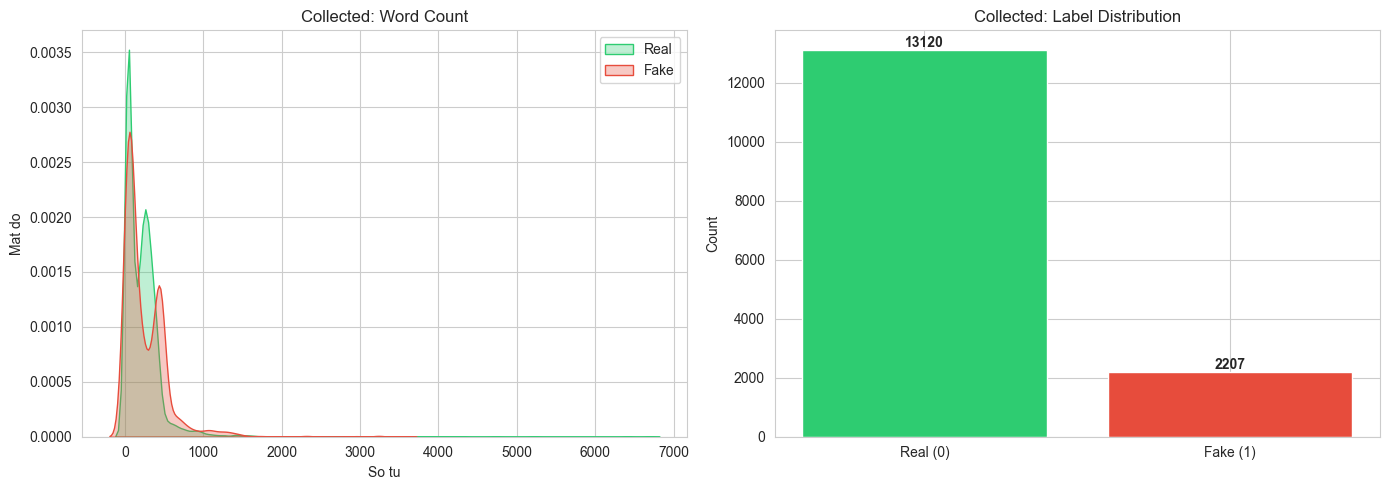

In [159]:
df_real = df_collected[df_collected["label"]==0]
df_fake = df_collected[df_collected["label"]==1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(df_real["word_count"], ax=axes[0], color="#2ecc71", label="Real", fill=True, alpha=0.3)
sns.kdeplot(df_fake["word_count"], ax=axes[0], color="#e74c3c", label="Fake", fill=True, alpha=0.3)
axes[0].set_title("Collected: Word Count")
axes[0].set_xlabel("So tu")
axes[0].set_ylabel("Mat do")
axes[0].legend()

counts = df_collected["label"].value_counts().sort_index()
bars = axes[1].bar(["Real (0)", "Fake (1)"], counts.values, color=["#2ecc71", "#e74c3c"])
axes[1].set_title("Collected: Label Distribution")
axes[1].set_ylabel("Count")
for bar, v in zip(bars, counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 100, str(v), ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### Data Quality - Collected

In [160]:
import re
from collections import Counter

def count_emoji(text):
    return len(emoji.emoji_list(str(text)))

def has_html(text):
    return bool(re.search(r"<[a-zA-Z][^>]*>", str(text)))

def has_url(text):
    return bool(re.search(r"https?://|www\.", str(text)))

def has_special_unicode(text):
    special = re.findall(r"[☀-⛿✀-➿⭐-⭕‼⁉▪-◾©®™ℹ]", str(text))
    return len(special)

def get_repeated_words(text, threshold=3):
    words = str(text).lower().split()
    counter = Counter(words)
    repeated = {w: c for w, c in counter.items() if c >= threshold and len(w) > 2}
    return len(repeated)

def detect_lang(text):
    try:
        return detect(str(text)[:500])
    except LangDetectException:
        return "unknown"

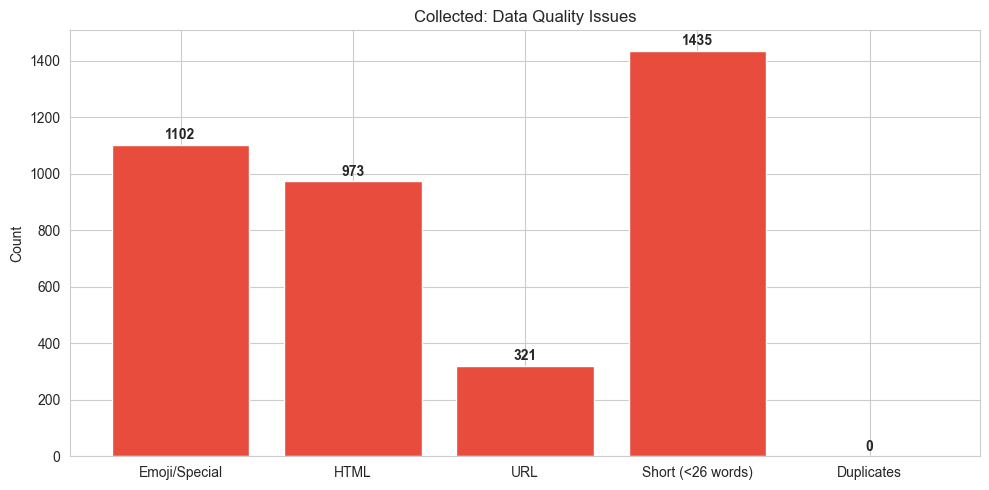

In [161]:
df_collected["emoji_count"] = df_collected["text"].apply(count_emoji)
df_collected["has_html"] = df_collected["text"].apply(has_html)
df_collected["has_url"] = df_collected["text"].apply(has_url)
df_collected["special_unicode"] = df_collected["text"].apply(has_special_unicode)
collected_10th_percentile = int(np.percentile(df_collected["word_count"], 10))
df_collected["is_short"] = df_collected["word_count"] < collected_10th_percentile
df_collected["has_emoji_or_special"] = (df_collected["emoji_count"] > 0) | (df_collected["special_unicode"] > 0)

issues = {
    "Emoji/Special": df_collected["has_emoji_or_special"].sum(),
    "HTML": df_collected["has_html"].sum(),
    "URL": df_collected["has_url"].sum(),
    f"Short (<{collected_10th_percentile} words)": df_collected["is_short"].sum(),
    "Duplicates": df_collected["text"].duplicated().sum()
}

fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#e74c3c" if v > 0 else "#2ecc71" for v in issues.values()]
bars = ax.bar(issues.keys(), issues.values(), color=colors)
ax.set_title("Collected: Data Quality Issues")
ax.set_ylabel("Count")
for bar, v in zip(bars, issues.values()):
    ax.text(bar.get_x() + bar.get_width()/2, v + 20, str(v), ha="center", fontweight="bold")
plt.tight_layout()
plt.show()

## TikTok Dataset

In [162]:
print("Category: fake/real")
print(df_tiktok["category"].value_counts())

Category: fake/real
category
fake    1590
real    1069
Name: count, dtype: int64


In [163]:
print("Sample Real video:")
sample = df_tiktok[df_tiktok["category"]=="real"].iloc[0]
print("Caption:", sample["desc"][:200])
print()
print("Transcript:", sample["text"][:400])

Sample Real video:
Caption: Một số cá nhân bị nghi ngờ đã sử dụng vật liệu không có khả năng chống cháy để che phủ giàn giáo xung quanh các tòa nhà thuộc khu chung cư vừa xảy ra hỏa hoạn ở Hồng Kông (Trung Quốc). Đây là kết luận

Transcript: Một số cá nhân đã bị nghi ngờ cố gắng dùng vật liệu không có khả năng chống cháy che phủ rán ráo xung quanh các tòa nhà ở khu trung cư vừa bị cháy ở Hồng Kông, Trung Quốc. Đây là kết luận của Ủy ban Độc lập Chống Tham nhũng Hồng Kông, Trung Quốc. Đội đặc nhiệm để điều tra đã lấy 20 mẫu lưới bảo vệ từ 4 tòa nhà bị cháy. Kiểm tra ban đầu cho thấy 7 mẫu không đạt tiêu chuẩn chống cháy. Trước đó, lo s


In [164]:
print("Sample Fake video:")
sample = df_tiktok[df_tiktok["category"]=="fake"].iloc[0]
print("Caption:", sample["desc"][:200])
print()
print("Transcript:", sample["text"][:400])

Sample Fake video:
Caption: Bí mật nasa che giấu, mặt trăng không hề cô đơn | Phần cuối #ufo #nasa #mattrang #alien

Transcript: Thế nhưng khi người dân quan sát, vô số chi tiết khiến ai nấy lạnh sống lưng. Ví dụ tại tọa độ 64 độ B95 độ T ở mặt sau mặt trăng có 2 khu vực bị làm mờ theo hình tam giác kỳ lạ. Khi phóng to, phần trên hiện ra như một khối hình chóp sắc nhọn, phần dưới lại giống một khối lập phương, hoàn toàn không giống kết quả từ tự nhiên. Ở hố va chạm Sokotsky, dù đã bị che mờ, người ta vẫn thấy một khối nhô c


In [165]:
df_tiktok["text_len"] = df_tiktok["text"].astype(str).apply(len)
df_tiktok["desc_len"] = df_tiktok["desc"].astype(str).apply(len)
df_tiktok["word_count"] = df_tiktok["text"].astype(str).apply(lambda x: len(x.split()))
df_tiktok[["text_len", "desc_len", "word_count"]].describe()

,text_len,desc_len,word_count
count,2659.000000,2659.000000,2659.000000
mean,1512.968785,141.209853,343.481008
std,2208.659560,123.391531,502.008708
min,70.000000,1.000000,16.000000
25%,745.500000,87.000000,169.000000
50%,1139.000000,119.000000,257.000000
75%,1574.500000,158.000000,353.000000
max,45762.000000,2032.000000,10462.000000


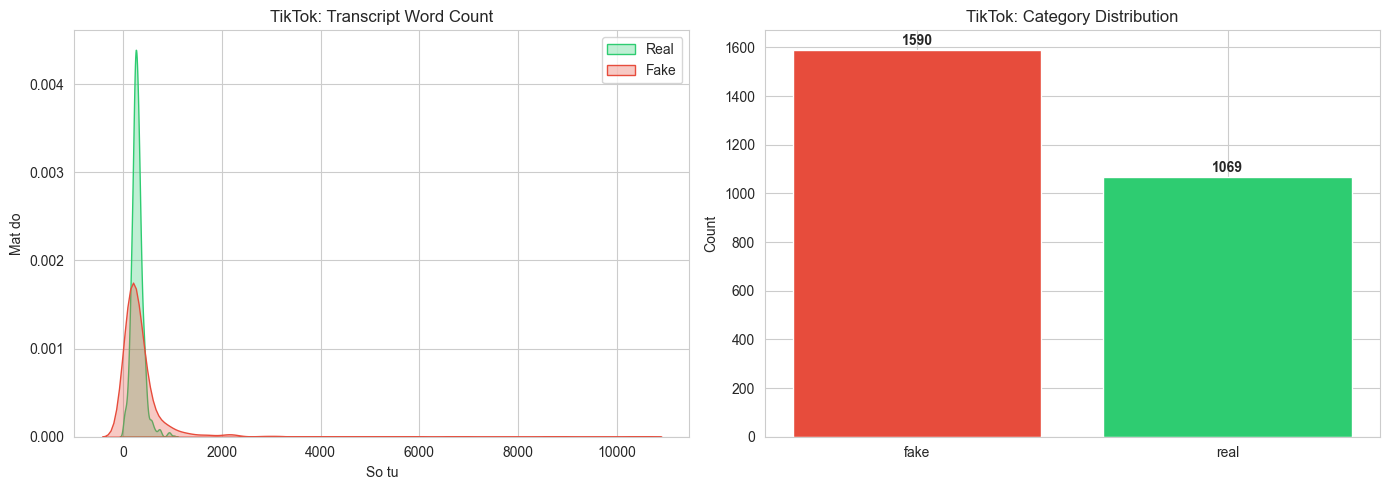

In [166]:
df_real = df_tiktok[df_tiktok["category"]=="real"]
df_fake = df_tiktok[df_tiktok["category"]=="fake"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(df_real["word_count"], ax=axes[0], color="#2ecc71", label="Real", fill=True, alpha=0.3)
sns.kdeplot(df_fake["word_count"], ax=axes[0], color="#e74c3c", label="Fake", fill=True, alpha=0.3)
axes[0].set_title("TikTok: Transcript Word Count")
axes[0].set_xlabel("So tu")
axes[0].set_ylabel("Mat do")
axes[0].legend()

counts = df_tiktok["category"].value_counts()
bars = axes[1].bar(counts.index, counts.values, color=["#e74c3c", "#2ecc71"])
axes[1].set_title("TikTok: Category Distribution")
axes[1].set_ylabel("Count")
for bar, v in zip(bars, counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 20, str(v), ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### Data Quality - TikTok

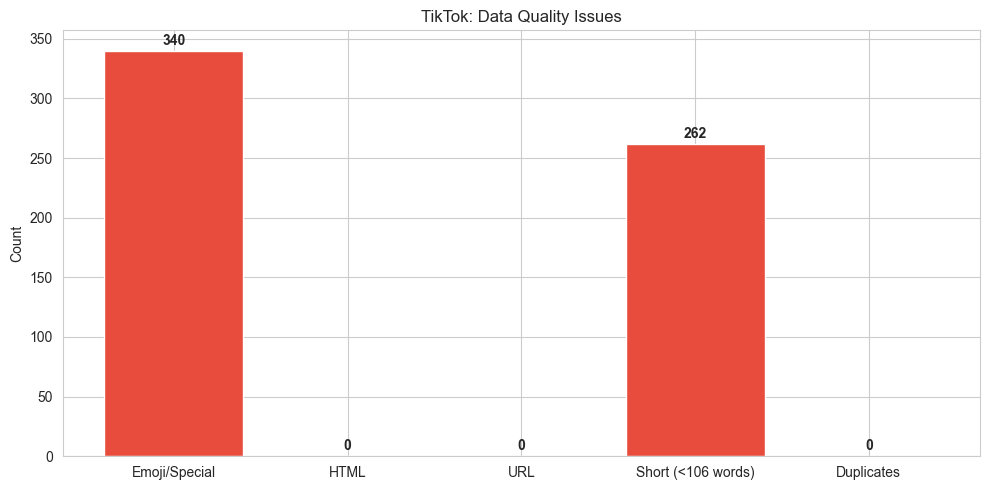

In [ ]:
df_tiktok["combined"] = df_tiktok["text"].fillna('').astype(str) + " " + df_tiktok["desc"].fillna('').astype(str)
df_tiktok["combined_word_count"] = df_tiktok["combined"].apply(lambda x: len(x.split()))
df_tiktok["emoji_count"] = df_tiktok["combined"].apply(count_emoji)
df_tiktok["special_unicode"] = df_tiktok["combined"].apply(has_special_unicode)
df_tiktok["has_html"] = df_tiktok["combined"].apply(has_html)
df_tiktok["has_url"] = df_tiktok["combined"].apply(has_url)
tiktok_10th_percentile = int(np.percentile(df_tiktok["combined_word_count"], 10))
df_tiktok["is_short"] = df_tiktok["combined_word_count"] < tiktok_10th_percentile
df_tiktok["has_emoji_or_special"] = (df_tiktok["emoji_count"] > 0) | (df_tiktok["special_unicode"] > 0)

issues = {
    "Emoji/Special": df_tiktok["has_emoji_or_special"].sum(),
    "HTML": df_tiktok["has_html"].sum(),
    "URL": df_tiktok["has_url"].sum(),
    f"Short": df_tiktok["is_short"].sum(),
    "Duplicates": df_tiktok["text"].duplicated().sum()
}

fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#e74c3c" if v > 0 else "#2ecc71" for v in issues.values()]
bars = ax.bar(issues.keys(), issues.values(), color=colors)
ax.set_title("TikTok: Data Quality Issues")
ax.set_ylabel("Count")
for bar, v in zip(bars, issues.values()):
    ax.text(bar.get_x() + bar.get_width()/2, v + 5, str(v), ha="center", fontweight="bold")
plt.tight_layout()
plt.show()

## Compare Datasets

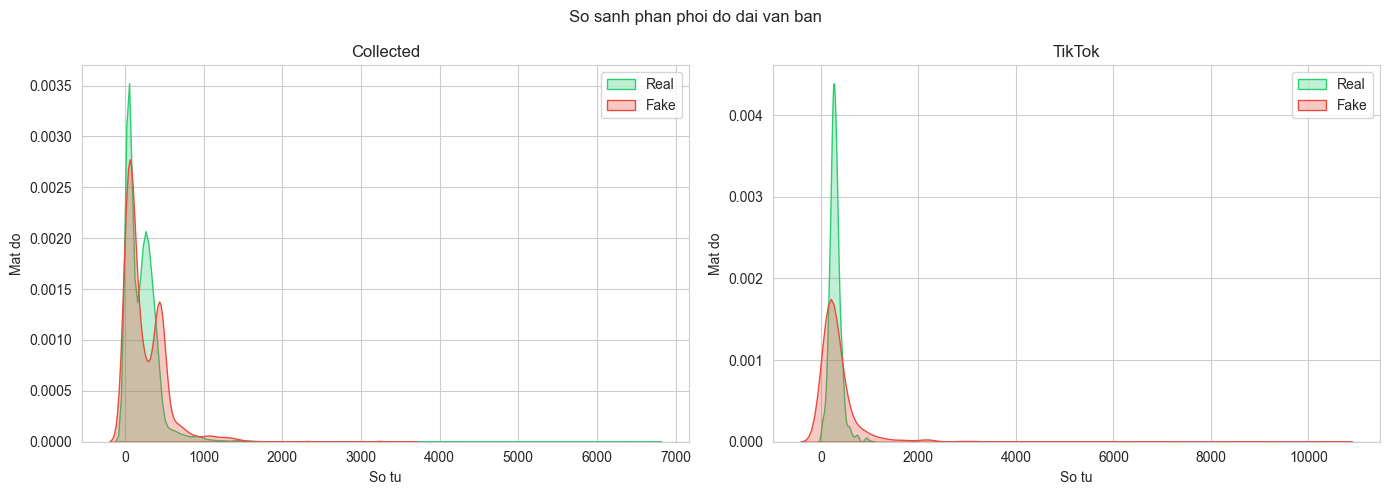

In [168]:
collected_real = df_collected[df_collected["label"]==0]
collected_fake = df_collected[df_collected["label"]==1]
tiktok_real = df_tiktok[df_tiktok["category"]=="real"]
tiktok_fake = df_tiktok[df_tiktok["category"]=="fake"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("So sanh phan phoi do dai van ban")

sns.kdeplot(collected_real["word_count"], ax=axes[0], color="#2ecc71", label="Real", fill=True, alpha=0.3)
sns.kdeplot(collected_fake["word_count"], ax=axes[0], color="#e74c3c", label="Fake", fill=True, alpha=0.3)
axes[0].set_title("Collected")
axes[0].set_xlabel("So tu")
axes[0].set_ylabel("Mat do")
axes[0].legend()

sns.kdeplot(tiktok_real["word_count"], ax=axes[1], color="#2ecc71", label="Real", fill=True, alpha=0.3)
sns.kdeplot(tiktok_fake["word_count"], ax=axes[1], color="#e74c3c", label="Fake", fill=True, alpha=0.3)
axes[1].set_title("TikTok")
axes[1].set_xlabel("So tu")
axes[1].set_ylabel("Mat do")
axes[1].legend()

plt.tight_layout()
plt.show()

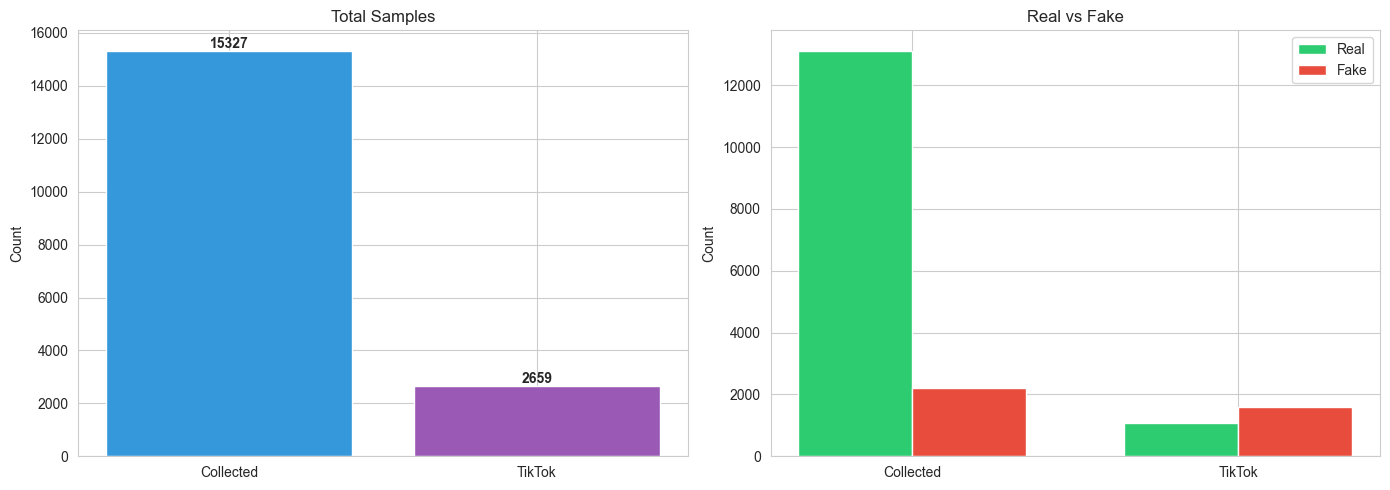

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars1 = axes[0].bar(["Collected", "TikTok"], [len(df_collected), len(df_tiktok)], color=["#3498db", "#9b59b6"])
axes[0].set_title("Total Samples")
axes[0].set_ylabel("Count")
for bar, v in zip(bars1, [len(df_collected), len(df_tiktok)]):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 100, str(v), ha="center", fontweight="bold")

x = np.arange(2)
width = 0.35
collected_real_n = (df_collected["label"]==0).sum()
collected_fake_n = (df_collected["label"]==1).sum()
tiktok_real_n = (df_tiktok["category"]=="real").sum()
tiktok_fake_n = (df_tiktok["category"]=="fake").sum()

axes[1].bar(x - width/2, [collected_real_n, tiktok_real_n], width, label="Real", color="#2ecc71")
axes[1].bar(x + width/2, [collected_fake_n, tiktok_fake_n], width, label="Fake", color="#e74c3c")
axes[1].set_title("Real vs Fake")
axes[1].set_xticks(x)
axes[1].set_xticklabels(["Collected", "TikTok"])
axes[1].legend()
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Content Length Distribution (Percentile)

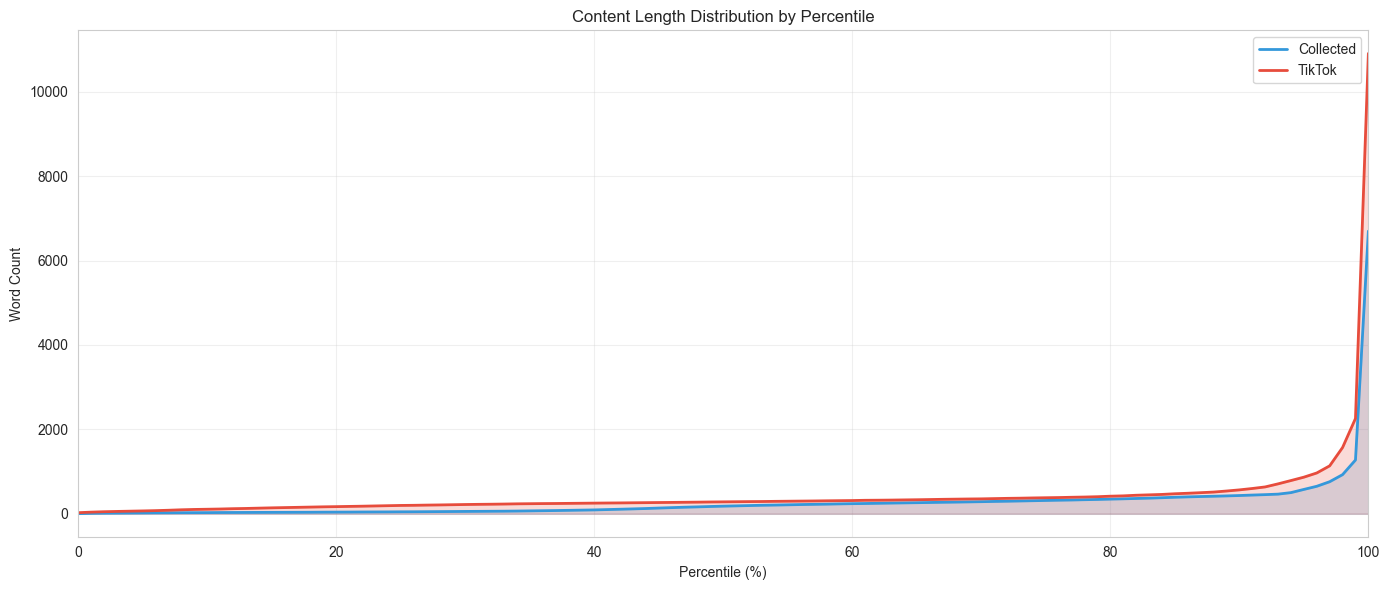

Collected Dataset:
  10th percentile: 26 words
  25th percentile: 45 words
  50th percentile: 179 words
  75th percentile: 314 words
  90th percentile: 431 words

TikTok Dataset:
  10th percentile: 106 words
  25th percentile: 196 words
  50th percentile: 281 words
  75th percentile: 378 words
  90th percentile: 564 words


In [170]:
df_collected['combined_word_count'] = df_collected['text'].astype(str).apply(lambda x: len(x.split()))
df_tiktok['combined_word_count'] = (df_tiktok['text'].fillna('').astype(str) + ' ' + df_tiktok['desc'].fillna('').astype(str)).apply(lambda x: len(x.split()))

percentiles = np.arange(0, 101, 1)
collected_percentiles = [np.percentile(df_collected['combined_word_count'], p) for p in percentiles]
tiktok_percentiles = [np.percentile(df_tiktok['combined_word_count'], p) for p in percentiles]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(percentiles, collected_percentiles, color='#3498db', linewidth=2, label='Collected')
ax.plot(percentiles, tiktok_percentiles, color='#e74c3c', linewidth=2, label='TikTok')
ax.fill_between(percentiles, collected_percentiles, alpha=0.2, color='#3498db')
ax.fill_between(percentiles, tiktok_percentiles, alpha=0.2, color='#e74c3c')
ax.set_xlabel('Percentile (%)')
ax.set_ylabel('Word Count')
ax.set_title('Content Length Distribution by Percentile')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

print('Collected Dataset:')
for p in [10, 25, 50, 75, 90]:
    print(f'  {p}th percentile: {int(np.percentile(df_collected["combined_word_count"], p))} words')
print()
print('TikTok Dataset:')
for p in [10, 25, 50, 75, 90]:
    print(f'  {p}th percentile: {int(np.percentile(df_tiktok["combined_word_count"], p))} words')

## Word Repetition Analysis

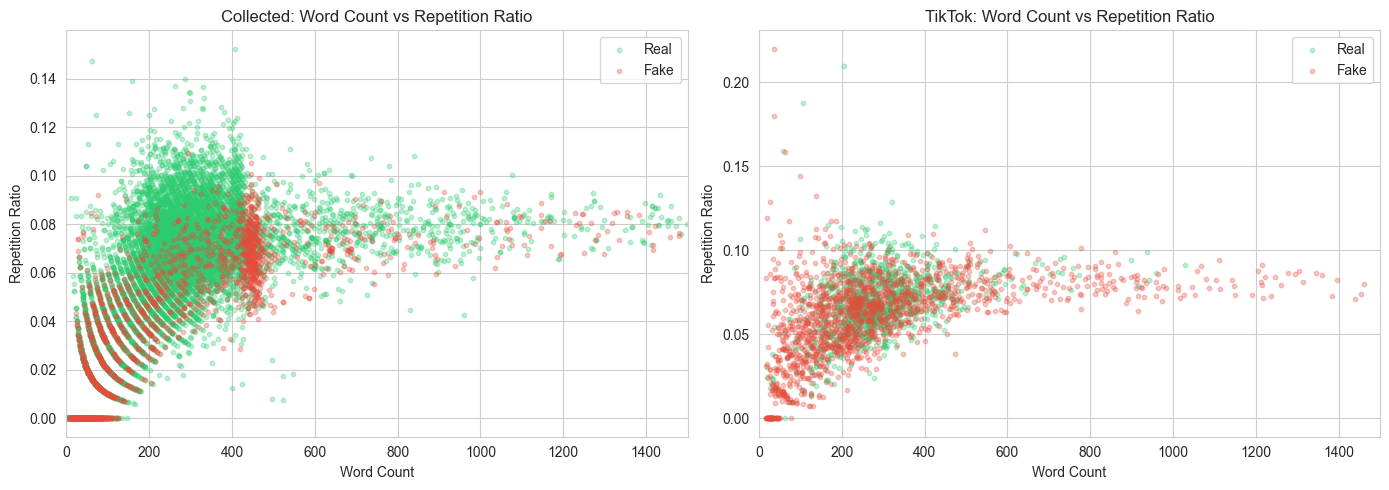

Collected Dataset:
  Real - Avg word count: 217.7 | Avg repetition ratio: 0.0437
  Fake - Avg word count: 258.5 | Avg repetition ratio: 0.0374

TikTok Dataset:
  Real - Avg word count: 285.2 | Avg repetition ratio: 0.0687
  Fake - Avg word count: 382.7 | Avg repetition ratio: 0.0618


In [171]:
def get_repetition_ratio(text, threshold=3):
    words = str(text).lower().split()
    if len(words) == 0:
        return 0
    counter = Counter(words)
    repeated = sum(1 for w, c in counter.items() if c >= threshold and len(w) > 2)
    return repeated / len(words)

df_collected["repetition_ratio"] = df_collected["text"].apply(get_repetition_ratio)
df_tiktok["combined_text"] = df_tiktok["text"].astype(str) + " " + df_tiktok["desc"].astype(str)
df_tiktok["repetition_ratio"] = df_tiktok["combined_text"].apply(get_repetition_ratio)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

collected_real = df_collected[df_collected["label"]==0]
collected_fake = df_collected[df_collected["label"]==1]
axes[0].scatter(collected_real["word_count"], collected_real["repetition_ratio"], alpha=0.3, c="#2ecc71", label="Real", s=10)
axes[0].scatter(collected_fake["word_count"], collected_fake["repetition_ratio"], alpha=0.3, c="#e74c3c", label="Fake", s=10)
axes[0].set_title("Collected: Word Count vs Repetition Ratio")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Repetition Ratio")
axes[0].legend()
axes[0].set_xlim(0, 1500)

tiktok_real = df_tiktok[df_tiktok["category"]=="real"]
tiktok_fake = df_tiktok[df_tiktok["category"]=="fake"]
axes[1].scatter(tiktok_real["word_count"], tiktok_real["repetition_ratio"], alpha=0.3, c="#2ecc71", label="Real", s=10)
axes[1].scatter(tiktok_fake["word_count"], tiktok_fake["repetition_ratio"], alpha=0.3, c="#e74c3c", label="Fake", s=10)
axes[1].set_title("TikTok: Word Count vs Repetition Ratio")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Repetition Ratio")
axes[1].legend()
axes[1].set_xlim(0, 1500)

plt.tight_layout()
plt.show()

print("Collected Dataset:")
print("  Real - Avg word count:", round(collected_real["word_count"].mean(), 1), "| Avg repetition ratio:", round(collected_real["repetition_ratio"].mean(), 4))
print("  Fake - Avg word count:", round(collected_fake["word_count"].mean(), 1), "| Avg repetition ratio:", round(collected_fake["repetition_ratio"].mean(), 4))
print()
print("TikTok Dataset:")
print("  Real - Avg word count:", round(tiktok_real["word_count"].mean(), 1), "| Avg repetition ratio:", round(tiktok_real["repetition_ratio"].mean(), 4))
print("  Fake - Avg word count:", round(tiktok_fake["word_count"].mean(), 1), "| Avg repetition ratio:", round(tiktok_fake["repetition_ratio"].mean(), 4))

## Summary

In [172]:
print("Collected Dataset:")
print("  Total:", len(df_collected))
print("  Real:", (df_collected["label"]==0).sum())
print("  Fake:", (df_collected["label"]==1).sum())
print("  Avg word count:", round(df_collected["word_count"].mean(), 1))
print()
print("TikTok Dataset:")
print("  Total:", len(df_tiktok))
print("  Real:", (df_tiktok["category"]=="real").sum())
print("  Fake:", (df_tiktok["category"]=="fake").sum())
print("  Avg word count:", round(df_tiktok["word_count"].mean(), 1))
print()
print("Combined total:", len(df_collected) + len(df_tiktok))

Collected Dataset:
  Total: 15327
  Real: 13120
  Fake: 2207
  Avg word count: 223.5

TikTok Dataset:
  Total: 2659
  Real: 1069
  Fake: 1590
  Avg word count: 343.5

Combined total: 17986


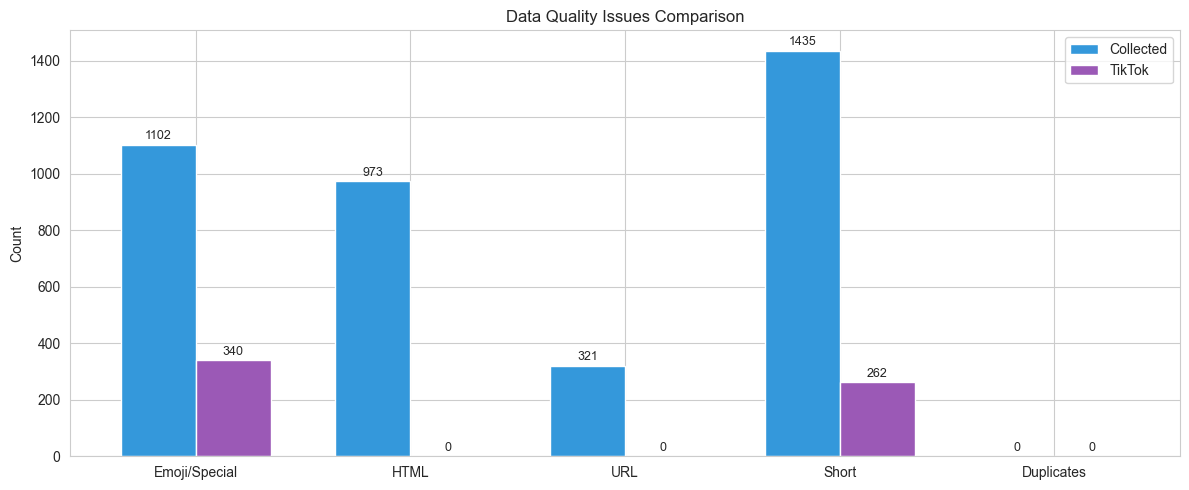

In [173]:
collected_10th = int(np.percentile(df_collected["word_count"], 10))
tiktok_10th = int(np.percentile(df_tiktok["combined_word_count"], 10))

issues_collected = [
    df_collected["has_emoji_or_special"].sum(),
    df_collected["has_html"].sum(),
    df_collected["has_url"].sum(),
    df_collected["is_short"].sum(),
    df_collected["text"].duplicated().sum()
]
issues_tiktok = [
    df_tiktok["has_emoji_or_special"].sum(),
    df_tiktok["has_html"].sum(),
    df_tiktok["has_url"].sum(),
    df_tiktok["is_short"].sum(),
    df_tiktok["text"].duplicated().sum()
]
labels = ["Emoji/Special", "HTML", "URL", f"Short", "Duplicates"]

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(labels))
width = 0.35
ax.bar(x - width/2, issues_collected, width, label="Collected", color="#3498db")
ax.bar(x + width/2, issues_tiktok, width, label="TikTok", color="#9b59b6")
ax.set_title("Data Quality Issues Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylabel("Count")

for i, (c, t) in enumerate(zip(issues_collected, issues_tiktok)):
    ax.text(i - width/2, c + 20, str(c), ha="center", fontsize=9)
    ax.text(i + width/2, t + 20, str(t), ha="center", fontsize=9)

plt.tight_layout()
plt.show()